----------------------
# **Image Preprocessing**

In [101]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot

img_size = 256

img_transforms = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ]
)

In [102]:
import torch
import torch.nn as nn

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [103]:
def load_img(image):
    img = Image.open(image)
    img = img_transforms(img).unsqueeze(0) # Batch = 1
    return img.to(device, torch.float)

content_img = load_img('/kaggle/input/style-transfer-data/content_img.jpg')
style_img1 = load_img('/kaggle/input/style-transfer-data/style_img.jpg')
style_img2 = load_img('/kaggle/input/style-transfer-data/style_img2.jpg')

print(content_img.shape)
print(content_img[0].shape)

torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])


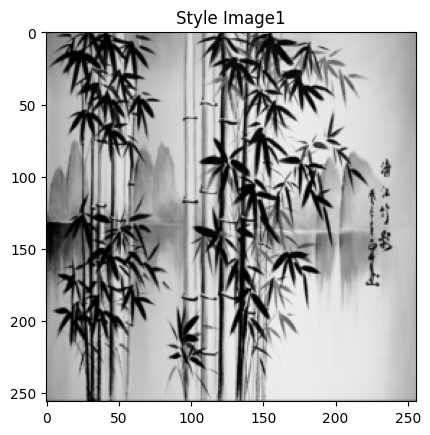

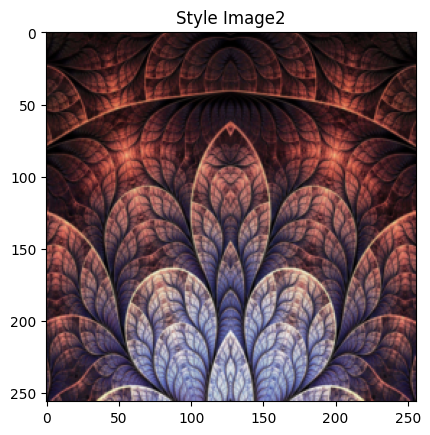

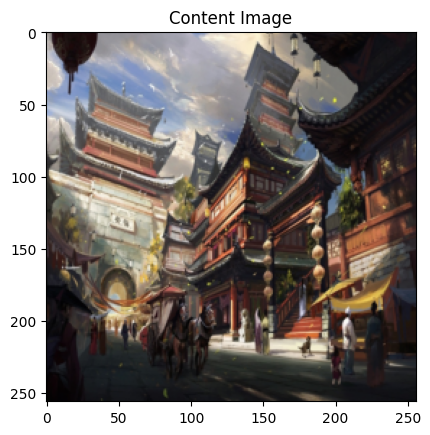

In [104]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img1, title='Style Image1')

plt.figure()
imshow(style_img2, title='Style Image2')

plt.figure()
imshow(content_img, title='Content Image')

In [105]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
        self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization().to(device)

<ipython-input-105-74401423e966>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
<ipython-input-105-74401423e966>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


------------
# **Content Loss**

In [106]:
"""
    Content loss as a direct distance metric ensures 
    that the structural elements and objects from 
    the content image remain recognizable in the generated image

    Content Loss is often "Distance Loss" because 
    we want to calculate the difference between pixels

    It's a big enough detail
    (Since Content Loss is usually objects, shapes, etc.)

    Style Loss on the other hand is the "Similarity"
    or "How this image looks to that image"
    You can't really define style by lines, shapes and all that
    but by how "similar" they are.
    
    The Styles cannot be "defined" or "learned" by just calculating
    difference between pixels
"""

'\n    Content loss as a direct distance metric ensures \n    that the structural elements and objects from \n    the content image remain recognizable in the generated image\n\n    Content Loss is often "Distance Loss" because \n    we want to calculate the difference between pixels\n\n    It\'s a big enough detail\n    (Since Content Loss is usually objects, shapes, etc.)\n\n    Style Loss on the other hand is the "Similarity"\n    or "How this image looks to that image"\n    You can\'t really define style by lines, shapes and all that\n    but by how "similar" they are.\n    \n    The Styles cannot be "defined" or "learned" by just calculating\n    difference between pixels\n'

In [107]:
# Content Loss
content_weight = 1 # How much it contributes to overall Loss
content_loss = nn.MSELoss()

-------------
# **Style Loss**

In [108]:
"""

    Style Loss is frequently 'Similarity'
    Since Styles cannot be defined by just comparing pixels
    We gotta compare the Similarity of the pixels
    => We could use metrics such as Cosine Sim, Corr-Coef, etc.

"""

"\n\n    Style Loss is frequently 'Similarity'\n    Since Styles cannot be defined by just comparing pixels\n    We gotta compare the Similarity of the pixels\n    => We could use metrics such as Cosine Sim, Corr-Coef, etc.\n\n"

In [109]:
# Style Loss
def gram_matrix (tensor):
    """
        Tensor: Output from FE

    We compute Gram_Matrix because it's kinda similar to
    how self-attention works.
    Style isn't just a SINGULAR pixel, it's usually the
    entirety of the image or, to a local level
    the nearby pixels
    => We gotta take information from other pixels
    => Compute Dot Product
    
    The Gram matrix calculation makes the style
    representation location-invariant, focusing on texture 
    and pattern relationships rather than specific
    content placement
    """

    # Input: Batch_size, Channel, Height, Width (1, 3, 224, 224)
    batch, channel, height, width = tensor.size()

    # Compress to 2D Matrix
    tensor = tensor.view(batch*channel, height*width) 

    # Compute Dot Product for global/local context
    gram = torch.mm(tensor, tensor.t())

    # Decompress
    return gram.div(batch*channel*height*width)

# How much it contributes to overall loss
style_weight = 1e6

# We can do Distance Loss if it went through gram_matrix
# because each pixel now has the "context" of other pixels
# Else just do Similarity Loss
style_loss = nn.MSELoss()

-------
# **Model**

In [110]:
from torchvision.models import vgg19, VGG19_Weights

model = vgg19(weights = VGG19_Weights.DEFAULT).features.eval()
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [111]:
# Compue Style Loss for each Layer
# Content Loss at 4th layer

content_layers = ['conv4']
style_layers = ['conv_1', 'conv_2',
                'conv_3', 'conv_4',
                'conv_5']

def get_features(model, img):
    layers = {
        "0": 'conv_1',
        "5": 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }

    features = {}
    img = normalization(img)

    for name, layer in model._modules.items():
        img = layer(img)
        if name in layers:
            # Log the Output of Image at each Layer
            features[layers[name]] = img

    return features

--------------
# **Dual Style**

In [112]:
def get_dual_style(style_features1, style_features2, style_layers):
    final_style_features = {}
    for layer in style_layers:
        sf1 = style_features1[layer]
        sf2 = style_features2[layer]
        sf1_size = int(sf1.size()[1] / 4)
        final_style_features[layer] = torch.concatenate([
                                        sf1[:,:sf1_size,:,:],
                                        sf2[:,sf1_size:,:,:]
                                    ], dim=1)
    return final_style_features

---------
# **Features Rotation**

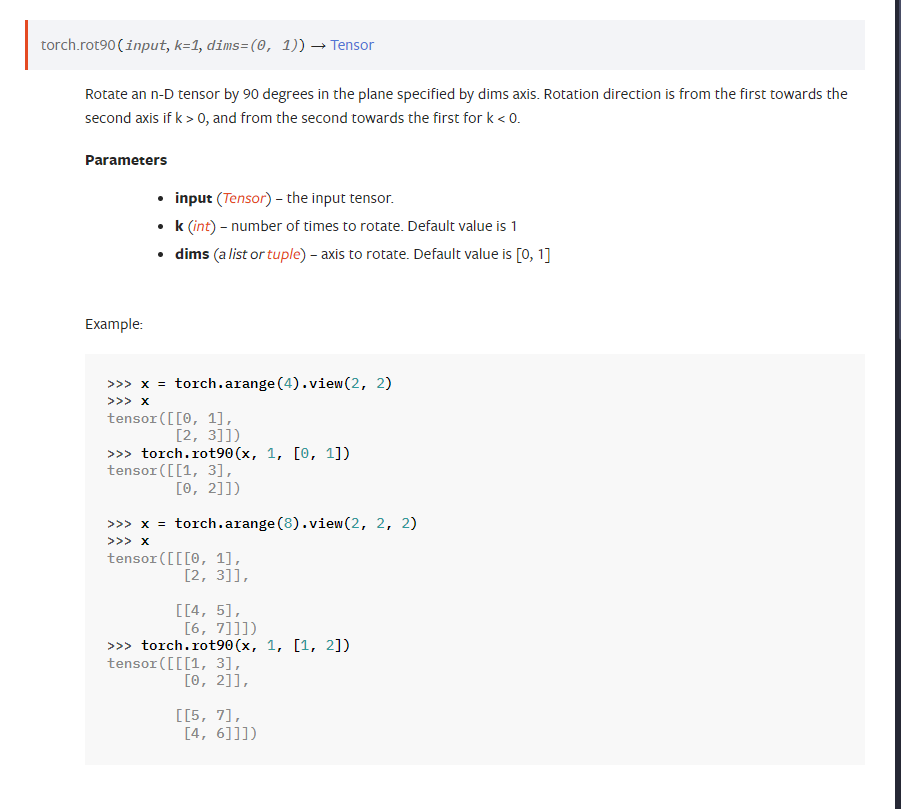

In [113]:
def features_rotation(style_features, style_layers):
    final_rot_style_features = {}

    # Take Final Rotation of each Layer
    for layer in style_layers:
        
        # Clone to prevent some stupid shit from happenning
        sf = style_features[layer].clone()
        
        # Only rotate Channel, Height and Width
        # Height and Width is one (Count as One Axis)
        
        # Rotate channel 90 Degrees
        rot90 = torch.rot90(sf.clone(), 1, (2, 3))

        # Rotate channel 180 Degrees
        rot180 = torch.rot90(rot90.clone(), 1, (2, 3))

        # Final Rotated Style Feature = sf + rot90 - rot180

        final_rot_style_features[layer] = sf + rot90 - rot180

    return final_rot_style_features

-------
# **Train**

In [114]:
content_features = get_features(model, content_img)
style_features1 = get_features(model, style_img1)
style_features2 = get_features(model, style_img2)
final_style_features = get_dual_style(style_features1, style_features2, style_layers)

In [115]:
import torch.optim as optim

target_img = content_img.clone().requires_grad_(True).to(device)
optimizer = optim.Adam([target_img], lr=0.02)

In [116]:
def style_tranfer(model, optimizer, target_img,
                   content_features, style_features,
                   style_layers, content_weight, style_weight):

    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)
    target_features = get_features(model, target_img)

    cont_loss = content_loss(content_features['conv_4'], target_features['conv_4'])

    style= 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_gram = gram_matrix(style_features[layer])
        style += style_loss(style_gram, target_gram)

    total_loss = cont_loss*content_weight + style*style_weight
    total_loss.backward(retain_graph=True)
    optimizer.step()
    return total_loss, cont_loss, style

In [117]:
STEPS = 500

for step in range(STEPS):
    optimizer.zero_grad()
    with torch.no_grad():
        target_img.clamp_(0, 1)

    total_loss, cont_loss, style = style_tranfer(model, optimizer, target_img,
                                                           content_features, final_style_features,
                                                           style_layers, content_weight, style_weight)
    if step % 100 == 99:
        print(f"Epoch [{step+1}/{STEPS}] Total loss: {total_loss.item():.6f} - \
                Content loss: {cont_loss.item():.6f} - Style loss: {style.item():.6f}")

    with torch.no_grad():
        target_img.clamp_(0, 1)

Epoch [100/500] Total loss: 100.528206 -                 Content loss: 23.110842 - Style loss: 0.000077
Epoch [200/500] Total loss: 95.173615 -                 Content loss: 23.099728 - Style loss: 0.000072
Epoch [300/500] Total loss: 92.767838 -                 Content loss: 23.059628 - Style loss: 0.000070
Epoch [400/500] Total loss: 91.286087 -                 Content loss: 23.138271 - Style loss: 0.000068
Epoch [500/500] Total loss: 90.461594 -                 Content loss: 23.192148 - Style loss: 0.000067


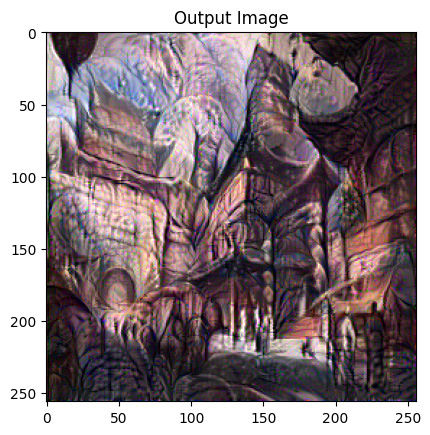

In [118]:
plt.figure()
imshow(target_img.detach(), title='Output Image')
plt.show()